# Telecom Churn - A Case Study

* Sunil Yadav | | yadav.sunil83@gmail.com | | +91-9620638383
* Jennis Vicente | | jennis.m.vicente@gmail.com | | +1-5733550173

# Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn


In this, We will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn

#### Understanding and Defining Churn

There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

 

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

 

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

 

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.

 

This project is based on the Indian and Southeast Asian market

# Business Goal

Retaining high profitable customers is the number one business goal

# Business Objective
The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

# Solution Approach

* Preprocess data (convert columns to appropriate formats, handle missing values, etc.)
* Conduct appropriate exploratory analysis to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).
* Derive new features.
* Reduce the number of variables using PCA.
* Train a variety of models, tune model hyperparameters, etc. (handle class imbalance using appropriate techniques).
* Evaluate the models using appropriate evaluation metrics. Note that is is more important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.
* Finally, choose a model based on some evaluation metric.


# Imports

In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import List, Sequence, Tuple
from enum import Enum, auto
import plotly.graph_objects as go
import plotly.figure_factory as ff
from IPython.display import display
import warnings
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from pandas.core.arrays.categorical import contains
from pandas._config.config import option_context
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from functools import reduce
from sklearn.feature_selection import RFECV, RFE
warnings.filterwarnings('ignore')

<h3>Pandas settings</h3>

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 500
pd.options.display.width = None
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

 # Utility Functions

In [3]:


class GraphType(Enum):
    """Graph Type Enum

    Args:
        Enum ([type]): Built-in Enum Class
    """
    BAR = auto()
    LINE = auto()


def plot_univariate_series(
        series: pd.Series,
        title: str,
        xlabel: str,
        ylabel: str,
        graph_type: GraphType = None,
        showlegend: bool = False,
        log_x=False,
        log_y=False,
        * args,
        **kwargs) -> None:
    """Bar plots a interger series

    Args:
        series (pd.Series): series to be plotted
        title (str): graph title
        xlabel (str): x-axis label
        ylabel (str): y-axis label
        graph_type (GraphType, optional): graph type
        showlegend (bool, optional): default False
        log_x (bool, optional): default False
        log_y (bool, optional): default False
    """
    labels = {"x": xlabel, "y": ylabel}
    fig = None
    if graph_type is None or graph_type == GraphType.BAR:
        fig = px.bar(x=series.index, y=series, color=series.index,
                     title=title, labels=labels, log_x=log_x, log_y=log_y, *args, **kwargs)

    if graph_type == GraphType.LINE:
        px.scatter(x=series.index, y=series, title=title, labels=labels, color=series.index, *args,
                   **kwargs)

    fig.update_layout(showlegend=showlegend)
    fig.show()


def get_univariate_cat_plot_strs(value: str) -> Tuple[str, str, str]:
    """Creates graph title, x-axis text and y-axis text for given value

    Args:
        value (str): column name

    Returns:
        Tuple[str, str, str]: title, x-axis text and y-axis text
    """
    full_name = " ".join([data_dict_as_dict.get(v.upper(), v.title()) for v in value.split("_")])
    if len(full_name) > 30:
        full_name = value
    count_str = full_name + ' Count'
    return count_str + ' Plot', full_name, count_str


def plot_cat_data(c: str, value_counts_ser: pd.Series, *args, **kwargs):
    """Plots the value count series

    Args:
        c ([str]): column name
        value_counts_ser ([pd.Series]): value counts series
    """
    t, xl, yl = get_univariate_cat_plot_strs(c)
    plot_univariate_series(value_counts_ser, t, xl, yl, *args, **kwargs)


def plot_univariate_categorical_columns(categorical_cols: Sequence[str], dataframe: pd.DataFrame, plot_limit: int = 30, *args, **kwargs) -> None:
    """plots categorical variable bars

    Args:
        categorical_cols (Sequence[str]): categorical columns
        dataframe (pd.DataFrame): DataFrame
    """
    for c in categorical_cols:
        value_counts_ser = dataframe[c].value_counts()
        cnt_len = len(value_counts_ser)
        if cnt_len > 1 and cnt_len < plot_limit:
            plot_cat_data(c, value_counts_ser, *args, **kwargs)


def plot_value_counts_frame(dataframe: pd.DataFrame, plot_limit: int = 30, *args, **kwargs) -> None:
    """plots categorical variable bars

    Args:
        dataframe (pd.DataFrame): dataframe with Column and Value Counts
        plot_limit (int, optional): Plot will be generated of catgory count is less than, Defaults to 30.
    """

    for i in range(len(dataframe)):
        current_row = dataframe.iloc[i]
        c = current_row["Column"]
        value_counts_ser = current_row['ValueCounts']
        cnt_len = len(value_counts_ser)
        if cnt_len > 1 and cnt_len <= plot_limit:
            plot_cat_data(c, value_counts_ser, *args, **kwargs)



## Read data

In [4]:
#  Read the data and Data Dictionary
churn_data = pd.read_csv("telecom_churn_data.csv")
data_dict = pd.read_excel("Data+Dictionary-+Telecom+Churn+Case+Study.xlsx")
data_dict = data_dict.sort_values(by='Acronyms    ')

In [5]:
data_dict_styled = data_dict.style.set_properties(**{'text-align': 'left'})
data_dict_styled.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
data_dict_styled.hide_index()

<h2>Data overview</h2>

In [6]:
churn_data.shape

(99999, 226)

In [7]:
churn_data.sample(20)


mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
59447     7002339637        109             0.0             0.0   
5379      7001735171        109             0.0             0.0   
64465     7001193622        109             0.0             0.0   
60668     7000535105        109             0.0             0.0   
25300     7000879276        109             0.0             0.0   
19266     7000747457        109             0.0             0.0   
84104     7000880137        109             0.0             0.0   
74238     7001554283        109             0.0             0.0   
91821     7002396901        109             0.0             0.0   
2696      7002211657        109             0.0             0.0   
97340     7001639334        109             0.0             0.0   
7254      7002050468        109             0.0             0.0   
22130     7001022245        109             0.0             0.0   
90146     7000933979        109             0.0             0.0   
32494     7001310574        109             0.0             0.0   
19433     7001008036        109             0.0             0.0   
28600     7002017831        109             0.0             0.0   
63398     7002282929        109             0.0             0.0   
86948     7000815385        109             0.0             0.0   
74303     7000058356        109             0.0             0.0   

       loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
59447             0.0            6/30/2014            7/31/2014   
5379              0.0            6/30/2014            7/31/2014   
64465             0.0            6/30/2014            7/31/2014   
60668             0.0            6/30/2014            7/31/2014   
25300             0.0            6/30/2014            7/31/2014   
19266             0.0            6/30/2014            7/31/2014   
84104             0.0            6/30/2014            7/31/2014   
74238             0.0            6/30/2014            7/31/2014   
91821             0.0            6/30/2014            7/31/2014   
2696              0.0            6/30/2014            7/31/2014   
97340             0.0            6/30/2014            7/31/2014   
7254              0.0            6/30/2014            7/31/2014   
22130             0.0            6/30/2014            7/31/2014   
90146             0.0            6/30/2014            7/31/2014   
32494             0.0            6/30/2014            7/31/2014   
19433             0.0            6/30/2014            7/31/2014   
28600             0.0            6/30/2014            7/31/2014   
63398             0.0            6/30/2014            7/31/2014   
86948             0.0            6/30/2014            7/31/2014   
74303             0.0            6/30/2014            7/31/2014   

      last_date_of_month_8 last_date_of_month_9   arpu_6   arpu_7   arpu_8  \
59447            8/31/2014            9/30/2014   73.174  113.647  110.755   
5379             8/31/2014            9/30/2014  195.188  164.463  190.426   
64465            8/31/2014            9/30/2014  372.801  159.097  128.333   
60668            8/31/2014            9/30/2014   94.967  154.062  190.231   
25300            8/31/2014            9/30/2014   51.910   28.350  137.720   
19266            8/31/2014            9/30/2014  527.776  329.377  274.175   
84104            8/31/2014            9/30/2014  978.734  396.135  809.561   
74238            8/31/2014            9/30/2014  401.398  298.897  249.027   
91821            8/31/2014            9/30/2014   70.862   86.013  130.540   
2696             8/31/2014            9/30/2014  148.042  128.615  224.109   
97340            8/31/2014            9/30/2014  343.574  499.050  451.404   
7254             8/31/2014            9/30/2014  368.248  277.724  195.834   
22130            8/31/2014            9/30/2014  432.802  267.114  286.552   
90146            8/31/2014            9/30/2014  195.669  163.487  264.388   
32494            8/31

In [8]:
", ".join(churn_data.columns)


'mobile_number, circle_id, loc_og_t2o_mou, std_og_t2o_mou, loc_ic_t2o_mou, last_date_of_month_6, last_date_of_month_7, last_date_of_month_8, last_date_of_month_9, arpu_6, arpu_7, arpu_8, arpu_9, onnet_mou_6, onnet_mou_7, onnet_mou_8, onnet_mou_9, offnet_mou_6, offnet_mou_7, offnet_mou_8, offnet_mou_9, roam_ic_mou_6, roam_ic_mou_7, roam_ic_mou_8, roam_ic_mou_9, roam_og_mou_6, roam_og_mou_7, roam_og_mou_8, roam_og_mou_9, loc_og_t2t_mou_6, loc_og_t2t_mou_7, loc_og_t2t_mou_8, loc_og_t2t_mou_9, loc_og_t2m_mou_6, loc_og_t2m_mou_7, loc_og_t2m_mou_8, loc_og_t2m_mou_9, loc_og_t2f_mou_6, loc_og_t2f_mou_7, loc_og_t2f_mou_8, loc_og_t2f_mou_9, loc_og_t2c_mou_6, loc_og_t2c_mou_7, loc_og_t2c_mou_8, loc_og_t2c_mou_9, loc_og_mou_6, loc_og_mou_7, loc_og_mou_8, loc_og_mou_9, std_og_t2t_mou_6, std_og_t2t_mou_7, std_og_t2t_mou_8, std_og_t2t_mou_9, std_og_t2m_mou_6, std_og_t2m_mou_7, std_og_t2m_mou_8, std_og_t2m_mou_9, std_og_t2f_mou_6, std_og_t2f_mou_7, std_og_t2f_mou_8, std_og_t2f_mou_9, std_og_t2c_mou_6,

In [9]:
churn_data.info(verbose=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

In [10]:
churn_data.describe(include='all').T

count unique        top   freq      mean  \
mobile_number                1e+05    NaN        NaN    NaN     7e+09   
circle_id                    1e+05    NaN        NaN    NaN       109   
loc_og_t2o_mou             9.9e+04    NaN        NaN    NaN         0   
std_og_t2o_mou             9.9e+04    NaN        NaN    NaN         0   
loc_ic_t2o_mou             9.9e+04    NaN        NaN    NaN         0   
last_date_of_month_6         99999      1  6/30/2014  99999       NaN   
last_date_of_month_7         99398      1  7/31/2014  99398       NaN   
last_date_of_month_8         98899      1  8/31/2014  98899       NaN   
last_date_of_month_9         98340      1  9/30/2014  98340       NaN   
arpu_6                       1e+05    NaN        NaN    NaN       283   
arpu_7                       1e+05    NaN        NaN    NaN       279   
arpu_8                       1e+05    NaN        NaN    NaN       279   
arpu_9                       1e+05    NaN        NaN    NaN       262   
onnet_mou_6               9.61e+04    NaN        NaN    NaN       132   
onnet_mou_7               9.61e+04    NaN        NaN    NaN       134   
onnet_mou_8               9.46e+04    NaN        NaN    NaN       133   
onnet_mou_9               9.23e+04    NaN        NaN    NaN       130   
offnet_mou_6              9.61e+04    NaN        NaN    NaN       198   
offnet_mou_7              9.61e+04    NaN        NaN    NaN       197   
offnet_mou_8              9.46e+04    NaN        NaN    NaN       197   
offnet_mou_9              9.23e+04    NaN        NaN    NaN       190   
roam_ic_mou_6             9.61e+04    NaN        NaN    NaN      9.95   
roam_ic_mou_7             9.61e+04    NaN        NaN    NaN      7.15   
roam_ic_mou_8             9.46e+04    NaN        NaN    NaN      7.29   
roam_ic_mou_9             9.23e+04    NaN        NaN    NaN      6.34   
roam_og_mou_6             9.61e+04    NaN        NaN    NaN      13.9   
roam_og_mou_7             9.61e+04    NaN        NaN    NaN      9.82   
roam_og_mou_8             9.46e+04    NaN        NaN    NaN      9.97   
roam_og_mou_9             9.23e+04    NaN        NaN    NaN      8.56   
loc_og_t2t_mou_6          9.61e+04    NaN        NaN    NaN      47.1   
loc_og_t2t_mou_7          9.61e+04    NaN        NaN    NaN      46.5   
loc_og_t2t_mou_8          9.46e+04    NaN        NaN    NaN      45.9   
loc_og_t2t_mou_9          9.23e+04    NaN        NaN    NaN      44.6   
loc_og_t2m_mou_6          9.61e+04    NaN        NaN    NaN      93.3   
loc_og_t2m_mou_7          9.61e+04    NaN        NaN    NaN      91.4   
loc_og_t2m_mou_8          9.46e+04    NaN        NaN    NaN      91.8   
loc_og_t2m_mou_9          9.23e+04    NaN        NaN    NaN      90.5   
loc_og_t2f_mou_6          9.61e+04    NaN        NaN    NaN      3.75   
loc_og_t2f_mou_7          9.61e+04    NaN        NaN    NaN      3.79   
loc_og_t2f_mou_8          9.46e+04    NaN        NaN    NaN      3.68   
loc_og_t2f_mou_9          9.23e+04    NaN        NaN    NaN      3.66   
loc_og_t2c_mou_6          9.61e+04    NaN        NaN    NaN      1.12   
loc_og_t2c_mou_7          9.61e+04    NaN        NaN    NaN      1.37   
loc_og_t2c_mou_8          9.46e+04    NaN        NaN    NaN      1.43   
loc_og_t2c_mou_9          9.23e+04    NaN        NaN    NaN      1.23   
loc_og_mou_6              9.61e+04    NaN        NaN    NaN       144   
loc_og_mou_7              9.61e+04    NaN        NaN    NaN       142   
loc_og_mou_8              9.46e+04    NaN        NaN    NaN       141   
loc_og_mou_9              9.23e+04    NaN        NaN    NaN       139   
std_og_t2t_mou_6          9.61e+04    NaN        NaN    NaN      79.8   
std_og_t2t_mou_7          9.61e+04    NaN        NaN    NaN      83.3   
std_og_t2t_mou_8          9.46e+04    NaN        NaN    NaN      83.3   
std_og_t2t_mou_9          9.23e+04    NaN        NaN    NaN      82.3   
std_og_t2m_mou_6          9.61e+04    NaN        NaN    NaN      87.3   
std_og_t2m_mou

In [11]:
#  Null percents


def print_null_percents(frame: pd.DataFrame, full: bool = False, display_cols=True):
    """Prints null columns perdent and count

    Args:
        frame (pd.DataFrame):Dataframe where null needs to be counted
        full (bool, optional): show all columns. Defaults to False.
        display_cols (bool, optional): show columns or not. Defaults to True.
    """
    null_counts = frame.isna().sum()
    if not full:
        null_counts = null_counts[null_counts > 0]
    if display_cols:
        display(round((null_counts/frame.shape[0])*100, 2).sort_values(ascending=False))
    print(f"Columns count with null: {len(null_counts[null_counts > 0])}")



In [12]:
print_null_percents(churn_data, True)

count_rech_2g_6             74.85
date_of_last_rech_data_6    74.85
count_rech_3g_6             74.85
av_rech_amt_data_6          74.85
max_rech_data_6             74.85
total_rech_data_6           74.85
arpu_3g_6                   74.85
arpu_2g_6                   74.85
night_pck_user_6            74.85
fb_user_6                   74.85
arpu_3g_7                   74.43
count_rech_2g_7             74.43
fb_user_7                   74.43
count_rech_3g_7             74.43
arpu_2g_7                   74.43
av_rech_amt_data_7          74.43
max_rech_data_7             74.43
night_pck_user_7            74.43
total_rech_data_7           74.43
date_of_last_rech_data_7    74.43
night_pck_user_9            74.08
date_of_last_rech_data_9    74.08
fb_user_9                   74.08
arpu_2g_9                   74.08
max_rech_data_9             74.08
arpu_3g_9                   74.08
total_rech_data_9           74.08
av_rech_amt_data_9          74.08
count_rech_3g_9             74.08
count_rech_2g_

Columns count with null: 166


In [13]:
# duplicate Rows Counts

len(churn_data) - len(churn_data.drop_duplicates())


0

In [14]:
#  value counts DataFrame
vc = []
for c in churn_data.columns:
    vc.append((c, churn_data[c].value_counts()))
vc = pd.DataFrame(vc, columns=['Column', "ValueCounts"])


# Data cleaning

In [15]:
# Make column names consistent
churn_data.rename({'aug_vbc_3g': 'vbc_3g_8', 'jul_vbc_3g': 'vbc_3g_7', 'jun_vbc_3g': 'vbc_3g_6', 'sep_vbc_3g': 'vbc_3g_9'}, axis=1, inplace=True)

In [16]:
# pr = ProfileReport(df, minimal=True)
# pr.to_widgets()


In [17]:

date_cols = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
             'date_of_last_rech_8', 'date_of_last_rech_9', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9']
cat_cols = ['fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9']
identity_cols = ['mobile_number', 'circle_id']
num_cols = [column for column in churn_data.columns if column not in identity_cols + date_cols + cat_cols]


In [18]:
# print the number of columns in each list
print(f"Number of ID cols: {len(identity_cols)}\nNumber of Date cols:{len(date_cols)}\nNumber of Numeric cols:{len(num_cols)}\nNumber of Category cols:{len(cat_cols)}")

Number of ID cols: 2
Number of Date cols:12
Number of Numeric cols:204
Number of Category cols:8


In [19]:
# convert date time data type
for dc in date_cols:
    churn_data[dc] = pd.to_datetime(churn_data[dc])

# Convert Categorical columns -- Need to set after imputation (as fill na for categorical values only allow values one from categorical)
# churn_data[cat_cols] = churn_data[cat_cols].astype('category')


In [20]:
#  Max and min dates in data
print(f"Max Date:\n{churn_data[date_cols].max().max()}")
print("-"*25)
print(f"Min Date:\n{churn_data[date_cols].min().min()}")


Max Date:
2014-09-30 00:00:00
-------------------------
Min Date:
2014-06-01 00:00:00


In [21]:
#  Max and min dates in data
print(f"Max Dates:\n{churn_data[date_cols].max()}")
print("-"*25)
print(f"Min Dates:\n{churn_data[date_cols].min()}")


Max Dates:
last_date_of_month_6       2014-06-30
last_date_of_month_7       2014-07-31
last_date_of_month_8       2014-08-31
last_date_of_month_9       2014-09-30
date_of_last_rech_6        2014-06-30
date_of_last_rech_7        2014-07-31
date_of_last_rech_8        2014-08-31
date_of_last_rech_9        2014-09-30
date_of_last_rech_data_6   2014-06-30
date_of_last_rech_data_7   2014-07-31
date_of_last_rech_data_8   2014-08-31
date_of_last_rech_data_9   2014-09-30
dtype: datetime64[ns]
-------------------------
Min Dates:
last_date_of_month_6       2014-06-30
last_date_of_month_7       2014-07-31
last_date_of_month_8       2014-08-31
last_date_of_month_9       2014-09-30
date_of_last_rech_6        2014-06-01
date_of_last_rech_7        2014-07-01
date_of_last_rech_8        2014-08-01
date_of_last_rech_9        2014-09-01
date_of_last_rech_data_6   2014-06-01
date_of_last_rech_data_7   2014-07-01
date_of_last_rech_data_8   2014-08-01
date_of_last_rech_data_9   2014-09-01
dtype: datetime64[

In [22]:
# Print value counts


def print_value_counts(frame: pd.DataFrame) -> None:
    frame = frame.sort_values(by='Column')
    for i in range(len(frame)):
        print("="*25)
        print(frame.iloc[i]['ValueCounts'])



In [23]:
# Cols with single value
single_valued_cols = vc[vc.apply(lambda r: len(r["ValueCounts"]) == 1, axis=1)]
print_value_counts(single_valued_cols)

109    99999
Name: circle_id, dtype: int64
6/30/2014    99999
Name: last_date_of_month_6, dtype: int64
7/31/2014    99398
Name: last_date_of_month_7, dtype: int64
8/31/2014    98899
Name: last_date_of_month_8, dtype: int64
9/30/2014    98340
Name: last_date_of_month_9, dtype: int64
0.0    98981
Name: loc_ic_t2o_mou, dtype: int64
0.0    98981
Name: loc_og_t2o_mou, dtype: int64
0.0    96062
Name: std_ic_t2o_mou_6, dtype: int64
0.0    96140
Name: std_ic_t2o_mou_7, dtype: int64
0.0    94621
Name: std_ic_t2o_mou_8, dtype: int64
0.0    92254
Name: std_ic_t2o_mou_9, dtype: int64
0.0    96062
Name: std_og_t2c_mou_6, dtype: int64
0.0    96140
Name: std_og_t2c_mou_7, dtype: int64
0.0    94621
Name: std_og_t2c_mou_8, dtype: int64
0.0    92254
Name: std_og_t2c_mou_9, dtype: int64
0.0    98981
Name: std_og_t2o_mou, dtype: int64


In [24]:

print(single_valued_cols['Column'])
print(len(single_valued_cols))

1                 circle_id
2            loc_og_t2o_mou
3            std_og_t2o_mou
4            loc_ic_t2o_mou
5      last_date_of_month_6
6      last_date_of_month_7
7      last_date_of_month_8
8      last_date_of_month_9
61         std_og_t2c_mou_6
62         std_og_t2c_mou_7
63         std_og_t2c_mou_8
64         std_og_t2c_mou_9
113        std_ic_t2o_mou_6
114        std_ic_t2o_mou_7
115        std_ic_t2o_mou_8
116        std_ic_t2o_mou_9
Name: Column, dtype: object
16


In [25]:
# Unique value counts less than 30(No specific reason to choose 30, after 30 categories it make sense to bucketization)
cols_less_30_values = vc[vc.apply(lambda r: len(r["ValueCounts"]) > 1 and len(r["ValueCounts"]) <= 30, axis=1)]
print_value_counts(cols_less_30_values)



0.0     15788
1.0      6742
2.0      1541
3.0       514
4.0       203
5.0       120
7.0        58
6.0        56
8.0        31
9.0        23
10.0       20
11.0       15
15.0        6
12.0        6
19.0        5
13.0        4
22.0        3
23.0        3
14.0        3
18.0        3
17.0        3
16.0        2
29.0        2
21.0        1
28.0        1
Name: count_rech_3g_6, dtype: int64
0.0     16294
1.0      6365
2.0      1718
3.0       515
4.0       231
5.0       140
6.0        90
7.0        57
8.0        33
9.0        24
10.0       19
11.0       15
12.0       15
14.0        9
13.0        8
15.0        8
17.0        4
19.0        4
18.0        4
22.0        3
21.0        3
20.0        3
16.0        3
24.0        2
34.0        1
31.0        1
23.0        1
35.0        1
Name: count_rech_3g_7, dtype: int64
0.0     16605
1.0      6648
2.0      1788
3.0       575
4.0       261
5.0       145
6.0        86
7.0        63
8.0        38
10.0       25
9.0        23
12.0       14
11.0       14
13.0

In [26]:
data_dict_as_dict = {}
for i in range(len(data_dict)):
    data_dict_as_dict[data_dict.iloc[i]['Acronyms    '].strip()] = data_dict.iloc[i]['Descriptions']

data_dict_as_dict['6'] = ' for Jun'
data_dict_as_dict['7'] = ' for Jul'
data_dict_as_dict['8'] = ' for Aug'
data_dict_as_dict['9'] = ' for Sep'


In [27]:
# plot_value_counts_frame(cols_less_30_values.sort_values(by='Column'), log_y=True)


# Imputation

# Categorical value imputation

In [28]:
# print categorical value counts
for cc in cat_cols:
    print(churn_data[cc].value_counts())


1.0    23000
0.0     2153
Name: fb_user_6, dtype: int64
1.0    23238
0.0     2333
Name: fb_user_7, dtype: int64
1.0    23463
0.0     2876
Name: fb_user_8, dtype: int64
1.0    22318
0.0     3604
Name: fb_user_9, dtype: int64
0.0    24522
1.0      631
Name: night_pck_user_6, dtype: int64
0.0    24982
1.0      589
Name: night_pck_user_7, dtype: int64
0.0    25790
1.0      549
Name: night_pck_user_8, dtype: int64
0.0    25508
1.0      414
Name: night_pck_user_9, dtype: int64


In [29]:
# Check for nulls in cate columns
churn_data[cat_cols].isna().sum()


fb_user_6           74846
fb_user_7           74428
fb_user_8           73660
fb_user_9           74077
night_pck_user_6    74846
night_pck_user_7    74428
night_pck_user_8    73660
night_pck_user_9    74077
dtype: int64

In [30]:
#  Fill NAs and convert to categorical
churn_data[cat_cols] = churn_data[cat_cols].apply(lambda x: x.fillna(-1))
churn_data[cat_cols] = churn_data[cat_cols].astype(int)
churn_data[cat_cols] = churn_data[cat_cols].astype('category')



In [31]:
print("Missing value ratio in categorical columns:\n")
display(churn_data[cat_cols].isnull().sum()*100/churn_data.shape[1])


Missing value ratio in categorical columns:



fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
fb_user_9           0.0
night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
night_pck_user_9    0.0
dtype: float64

In [32]:
# data preview
churn_data[cat_cols]


fb_user_6 fb_user_7 fb_user_8 fb_user_9 night_pck_user_6  \
0             1         1         1        -1                0   
1            -1         1         1        -1               -1   
2            -1        -1        -1         1               -1   
3            -1        -1        -1        -1               -1   
4             0        -1        -1        -1                0   
...         ...       ...       ...       ...              ...   
99994        -1        -1        -1        -1               -1   
99995        -1        -1        -1        -1               -1   
99996         1        -1        -1        -1                0   
99997         1         1         1         1                0   
99998         1        -1        -1        -1                0   

      night_pck_user_7 night_pck_user_8 night_pck_user_9  
0                    0                0               -1  
1                    0                0               -1  
2                   -1               -1                0  
3                   -1               -1               -1  
4                   -1               -1               -1  
...                ...              ...              ...  
99994               -1               -1               -1  
99995               -1               -1               -1  
99996               -1               -1               -1  
99997                0                0                0  
99998               -1               -1               -1  

[99999 rows x 8 columns]

# Imputing Numerics

In [33]:
# Considering if recharge value is blank then person did not recharge and we can put zero for recharge as this is currency and defauld zero is good option
zero_impute = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
               'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
               'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9']

In [34]:
# Fill recharge amount NAs to zero
churn_data[zero_impute] = churn_data[zero_impute].apply(lambda x: x.fillna(0))


In [35]:
print("Missing value ratio in zero imputed columns:\n")
display(churn_data[zero_impute].isnull().sum()*100/churn_data.shape[1])


Missing value ratio in zero imputed columns:



total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
total_rech_data_9     0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
av_rech_amt_data_9    0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
max_rech_data_9       0.0
dtype: float64

In [36]:
# Re-look on missing percentage
print_null_percents(churn_data)


arpu_2g_6                   74.85
arpu_3g_6                   74.85
date_of_last_rech_data_6    74.85
count_rech_3g_6             74.85
count_rech_2g_6             74.85
arpu_2g_7                   74.43
arpu_3g_7                   74.43
count_rech_3g_7             74.43
date_of_last_rech_data_7    74.43
count_rech_2g_7             74.43
arpu_2g_9                   74.08
date_of_last_rech_data_9    74.08
arpu_3g_9                   74.08
count_rech_3g_9             74.08
count_rech_2g_9             74.08
arpu_2g_8                   73.66
date_of_last_rech_data_8    73.66
arpu_3g_8                   73.66
count_rech_3g_8             73.66
count_rech_2g_8             73.66
loc_ic_mou_9                 7.75
loc_og_t2f_mou_9             7.75
isd_og_mou_9                 7.75
loc_og_t2c_mou_9             7.75
std_ic_t2o_mou_9             7.75
loc_og_mou_9                 7.75
loc_og_t2m_mou_9             7.75
std_ic_t2f_mou_9             7.75
std_og_t2t_mou_9             7.75
std_og_mou_9  

Columns count with null: 146


In [37]:
# columns with more than 70% missing values
MISSING_PERCENT_THRESHOLD = 70
null_counts = churn_data.isna().sum()
null_counts = null_counts[null_counts > 0]
null_percentage = round((null_counts/churn_data.shape[0])*100, 2).sort_values(ascending=False)
null_percentage = null_percentage[null_percentage >= MISSING_PERCENT_THRESHOLD]
display(null_percentage)


arpu_2g_6                   74.85
arpu_3g_6                   74.85
date_of_last_rech_data_6    74.85
count_rech_3g_6             74.85
count_rech_2g_6             74.85
arpu_2g_7                   74.43
arpu_3g_7                   74.43
count_rech_3g_7             74.43
date_of_last_rech_data_7    74.43
count_rech_2g_7             74.43
arpu_2g_9                   74.08
date_of_last_rech_data_9    74.08
arpu_3g_9                   74.08
count_rech_3g_9             74.08
count_rech_2g_9             74.08
arpu_2g_8                   73.66
date_of_last_rech_data_8    73.66
arpu_3g_8                   73.66
count_rech_3g_8             73.66
count_rech_2g_8             73.66
dtype: float64

In [38]:
#  lets have a look on missing data columns
churn_data[null_percentage.index].sample(20)


arpu_2g_6  arpu_3g_6 date_of_last_rech_data_6  count_rech_3g_6  \
15165        NaN        NaN                      NaT              NaN   
1985         NaN        NaN                      NaT              NaN   
79752        NaN        NaN                      NaT              NaN   
23836        NaN        NaN                      NaT              NaN   
88795        NaN        NaN                      NaT              NaN   
93748        NaN        NaN                      NaT              NaN   
85522        NaN        NaN                      NaT              NaN   
47041        NaN        NaN                      NaT              NaN   
42865        NaN        NaN                      NaT              NaN   
21795        NaN        NaN                      NaT              NaN   
56676     337.84     312.45               2014-06-21              2.0   
19102        NaN        NaN                      NaT              NaN   
55164        NaN        NaN                      NaT              NaN   
46653      16.10       0.00               2014-06-16              0.0   
6979         NaN        NaN                      NaT              NaN   
92442        NaN        NaN                      NaT              NaN   
33275        NaN        NaN                      NaT              NaN   
65994      77.68      77.68               2014-06-24              1.0   
92655        NaN        NaN                      NaT              NaN   
5108         NaN        NaN                      NaT              NaN   

       count_rech_2g_6  arpu_2g_7  arpu_3g_7  count_rech_3g_7  \
15165              NaN        NaN        NaN              NaN   
1985               NaN     127.10       0.00              0.0   
79752              NaN        NaN        NaN              NaN   
23836              NaN        NaN        NaN              NaN   
88795              NaN        NaN        NaN              NaN   
93748              NaN        NaN        NaN              NaN   
85522              NaN        NaN        NaN              NaN   
47041              NaN        NaN        NaN              NaN   
42865              NaN        NaN        NaN              NaN   
21795              NaN       0.00       0.00              0.0   
56676              0.0     150.67     150.68              1.0   
19102              NaN        NaN        NaN              NaN   
55164              NaN        NaN        NaN              NaN   
46653              5.0      16.80       0.00              0.0   
6979               NaN        NaN        NaN              NaN   
92442              NaN        NaN        NaN              NaN   
33275              NaN        NaN        NaN              NaN   
65994              0.0       0.00       0.48              0.0   
92655              NaN      63.96     155.83              1.0   
5108               NaN        NaN        NaN              NaN   

      date_of_last_rech_data_7  count_rech_2g_7  arpu_2g_9  \
15165                      NaT              NaN        NaN   
1985                2014-07-17              1.0        NaN   
79752                      NaT              NaN        NaN   
23836                      NaT              NaN       0.00   
88795                      NaT              NaN        NaN   
93748                      NaT              NaN        NaN   
85522                      NaT              NaN        NaN   
47041                      NaT              NaN        NaN   
42865                      NaT              NaN        NaN   
21795               2014-07-07              1.0        NaN   
56676               2014-07-11              0.0     280.02   
19102                      NaT              NaN        NaN   
55164                      NaT              NaN        NaN   
46653               2014-07-31              4.0      21.95   
6979                       NaT              NaN        NaN   
92442                      NaT              NaN        NaN   
33275                      NaT              NaN      

In [39]:
missing_above_threshold = churn_data[null_percentage.index].describe(include='all').T
missing_above_threshold["missing_per"] = null_percentage
missing_above_threshold

count unique        top  freq      first  \
arpu_2g_6                 2.52e+04    NaN        NaT   NaN        NaT   
arpu_3g_6                 2.52e+04    NaN        NaT   NaN        NaT   
date_of_last_rech_data_6     25153     30 2014-06-30  1888 2014-06-01   
count_rech_3g_6           2.52e+04    NaN        NaT   NaN        NaT   
count_rech_2g_6           2.52e+04    NaN        NaT   NaN        NaT   
arpu_2g_7                 2.56e+04    NaN        NaT   NaN        NaT   
arpu_3g_7                 2.56e+04    NaN        NaT   NaN        NaT   
count_rech_3g_7           2.56e+04    NaN        NaT   NaN        NaT   
date_of_last_rech_data_7     25571     31 2014-07-31  1813 2014-07-01   
count_rech_2g_7           2.56e+04    NaN        NaT   NaN        NaT   
arpu_2g_9                 2.59e+04    NaN        NaT   NaN        NaT   
date_of_last_rech_data_9     25922     30 2014-09-29  2329 2014-09-01   
arpu_3g_9                 2.59e+04    NaN        NaT   NaN        NaT   
count_rech_3g_9           2.59e+04    NaN        NaT   NaN        NaT   
count_rech_2g_9           2.59e+04    NaN        NaT   NaN        NaT   
arpu_2g_8                 2.63e+04    NaN        NaT   NaN        NaT   
date_of_last_rech_data_8     26339     31 2014-08-31  1998 2014-08-01   
arpu_3g_8                 2.63e+04    NaN        NaT   NaN        NaT   
count_rech_3g_8           2.63e+04    NaN        NaT   NaN        NaT   
count_rech_2g_8           2.63e+04    NaN        NaT   NaN        NaT   

                               last   mean   std   min  25%   50%  75%  \
arpu_2g_6                       NaT   86.4   173 -35.8    0  10.8  122   
arpu_3g_6                       NaT   89.6   193 -30.8    0  0.48  122   
date_of_last_rech_data_6 2014-06-30    NaN   NaN   NaN  NaN   NaN  NaN   
count_rech_3g_6                 NaT  0.599  1.27     0    0     0    1   
count_rech_2g_6                 NaT   1.86  2.57     0    1     1    2   
arpu_2g_7                       NaT   85.9   176 -15.5    0  8.81  122   
arpu_3g_7                       NaT   89.4   196   -26    0  0.42  120   
count_rech_3g_7                 NaT  0.622  1.39     0    0     0    1   
date_of_last_rech_data_7 2014-07-31    NaN   NaN   NaN  NaN   NaN  NaN   
count_rech_2g_7                 NaT   2.04  2.77     0    1     1    2   
arpu_2g_9                       NaT   93.7   171 -45.7    0  14.8  140   
date_of_last_rech_data_9 2014-09-30    NaN   NaN   NaN  NaN   NaN  NaN   
arpu_3g_9                       NaT    100   216 -71.1    0   2.6  140   
count_rech_3g_9                 NaT  0.659  1.41     0    0     0    1   
count_rech_2g_9                 NaT   1.78  2.21     0    1     1    2   
arpu_2g_8                       NaT   86.6   168 -55.8    0  9.27  122   
date_of_last_rech_data_8 2014-08-31    NaN   NaN   NaN  NaN   NaN  NaN   
arpu_3g_8                       NaT   91.2   188 -24.5    0  0.88  122   
count_rech_3g_8                 NaT  0.636  1.42     0    0     0    1   
count_rech_2g_8                 NaT   2.02  2.72     0    1     1    2   

                               max  missing_per  
arpu_2g_6                 6.43e+03        74.85  
arpu_3g_6                 6.36e+03        74.85  
date_of_last_rech_data_6       NaN        74.85  
count_rech_3g_6                 29        74.85  
count_rech_2g_6                 42        74.85  
arpu_2g_7                 4.81e+03        74.43  
arpu_3g_7                 4.98e+03        74.43  
count_rech_3g_7                 35        74.43  
date_of_last_rech_data_7       NaN        74.43  
count_rech_2g_7                 48        74.43  
arpu_2g_9                 3.47e+03        74.08  
date_of_last_rech_data_9       NaN        74.08  
arpu_3g_9                 1.39e+04        74.08  
count_rech_3g_9                 49        74.08  
count_rech_2g_9                 40        74.08  
arpu_2g_8                 3.48e+03        73.66  
date_of_last_rech_data_8       NaN        73.66  
arpu_3g_8                 3.72e+03      

# Dropping columns

In [40]:
# Dropping Id columns
print(churn_data.shape)
churn_data.drop(identity_cols, axis=1, inplace=True)
churn_data.shape

(99999, 226)


(99999, 224)

In [41]:
# Dropping columns wit high missing values
print(churn_data.shape)
churn_data.drop(null_percentage.index, axis=1, inplace=True)

churn_data.shape

(99999, 224)


(99999, 204)

In [42]:
# One valued columns as they will not produce any value
one_valued_columns = [c for c in churn_data.columns if len(churn_data[c].value_counts()) == 1]
one_valued_columns


['loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_t2c_mou_9',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'std_ic_t2o_mou_9']

In [43]:
#  Dropping single valued columns
print(churn_data.shape)
churn_data.drop(one_valued_columns, axis=1, inplace=True)
churn_data.shape

(99999, 204)


(99999, 189)

In [44]:
#  Dropping date columns columns
print(churn_data.shape)
churn_data.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9'], axis=1, inplace=True)
churn_data.shape


(99999, 189)


(99999, 185)

In [45]:
churn_data.info(verbose=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 185 columns):
 #   Column              Dtype   
---  ------              -----   
 0   arpu_6              float64 
 1   arpu_7              float64 
 2   arpu_8              float64 
 3   arpu_9              float64 
 4   onnet_mou_6         float64 
 5   onnet_mou_7         float64 
 6   onnet_mou_8         float64 
 7   onnet_mou_9         float64 
 8   offnet_mou_6        float64 
 9   offnet_mou_7        float64 
 10  offnet_mou_8        float64 
 11  offnet_mou_9        float64 
 12  roam_ic_mou_6       float64 
 13  roam_ic_mou_7       float64 
 14  roam_ic_mou_8       float64 
 15  roam_ic_mou_9       float64 
 16  roam_og_mou_6       float64 
 17  roam_og_mou_7       float64 
 18  roam_og_mou_8       float64 
 19  roam_og_mou_9       float64 
 20  loc_og_t2t_mou_6    float64 
 21  loc_og_t2t_mou_7    float64 
 22  loc_og_t2t_mou_8    float64 
 23  loc_og_t2t_mou_9    float64 
 24  l

# Imputing with IterativeImputer imputer

In [46]:
non_impute_cols = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9']

In [47]:
impute_ds = churn_data.drop(non_impute_cols, axis=1)

iterative_imputer = IterativeImputer(random_state=997, max_iter=1)
churn_data_imputed = iterative_imputer.fit_transform(impute_ds)
churn_data_imputed = pd.DataFrame(churn_data_imputed, columns=impute_ds.columns)
print_null_percents(churn_data_imputed, full=True)



vbc_3g_9              0.0
loc_ic_mou_9          0.0
spl_og_mou_9          0.0
spl_og_mou_8          0.0
spl_og_mou_7          0.0
spl_og_mou_6          0.0
isd_og_mou_9          0.0
isd_og_mou_8          0.0
isd_og_mou_7          0.0
isd_og_mou_6          0.0
std_og_mou_9          0.0
std_og_mou_8          0.0
std_og_mou_7          0.0
std_og_mou_6          0.0
std_og_t2f_mou_9      0.0
std_og_t2f_mou_8      0.0
std_og_t2f_mou_7      0.0
std_og_t2f_mou_6      0.0
std_og_t2m_mou_9      0.0
std_og_t2m_mou_8      0.0
std_og_t2m_mou_7      0.0
og_others_6           0.0
og_others_7           0.0
og_others_8           0.0
loc_ic_t2m_mou_7      0.0
loc_ic_mou_7          0.0
loc_ic_mou_6          0.0
loc_ic_t2f_mou_9      0.0
loc_ic_t2f_mou_8      0.0
loc_ic_t2f_mou_7      0.0
loc_ic_t2f_mou_6      0.0
loc_ic_t2m_mou_9      0.0
loc_ic_t2m_mou_8      0.0
loc_ic_t2m_mou_6      0.0
og_others_9           0.0
loc_ic_t2t_mou_9      0.0
loc_ic_t2t_mou_8      0.0
loc_ic_t2t_mou_7      0.0
loc_ic_t2t_m

Columns count with null: 0


In [48]:
# merge non imputed columns to imputed columns
churn_data_imputed = pd.concat([churn_data_imputed, churn_data[non_impute_cols]], axis=1)
churn_data_imputed.shape


(99999, 185)

In [49]:
churn_data_imputed.isnull().sum().sum()

0

# Filtering

Those who have recharged with an amount more than or equal to X, where X is the **70th percentile ** of the **average recharge amount** in the **first two months** (the good phase).

In [50]:
# Calculate data recharge amount
churn_data_imputed['total_data_rech_6'] = churn_data_imputed['total_rech_data_6'] * churn_data_imputed['av_rech_amt_data_6']
churn_data_imputed['total_data_rech_7'] = churn_data_imputed['total_rech_data_7'] * churn_data_imputed['av_rech_amt_data_7']


In [51]:
# calculate total recharge amount
churn_data_imputed['amt_data_6'] = churn_data_imputed['total_rech_amt_6'] + churn_data_imputed['total_data_rech_6']
churn_data_imputed['amt_data_7'] = churn_data_imputed['total_rech_amt_7'] + churn_data_imputed['total_data_rech_7']


In [52]:
# calculate mean of month 6 and 7
churn_data_imputed['av_amt_data_6_7'] = (churn_data_imputed['amt_data_6'] + churn_data_imputed['amt_data_7'])/2


In [53]:
# threshold value
threshold_value = churn_data_imputed['av_amt_data_6_7'].quantile(0.7)
print(f"Threshold value to filter the users is: {threshold_value}")


Threshold value to filter the users is: 478.0


In [54]:
high_value_users = churn_data_imputed[churn_data_imputed['av_amt_data_6_7'] >= threshold_value]
high_value_users = high_value_users.reset_index()
high_value_users.shape  # (~29.9k rows)


(30001, 191)

In [55]:
churn_data_imputed.isnull().sum().sum()

0

Calculate churn based on total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9

In [56]:
# Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.
high_value_users['churn'] = high_value_users.apply(lambda x:  1 if x['total_ic_mou_9'] + x['total_og_mou_9']+x['vol_2g_mb_9']+x['vol_3g_mb_9'] == 0 else 0, axis=1)
high_value_users['churn'] = high_value_users['churn'].astype('category')
high_value_users['churn'].value_counts()


0    27560
1     2441
Name: churn, dtype: int64

# Remove all the attributes corresponding to the churn phase

In [57]:
# get churn month columns
churn_phase_cols = [c for c in high_value_users.columns if str(c).endswith("_9")]
churn_phase_cols

['arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'last_day_rch_amt_9',
 'total_rech_data_9',
 'max_rech_data_9',
 'av_rech_amt_data_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9',
 'vbc_3g_9',
 'night_pck_user_9',
 'fb_user_9']

In [58]:
# drop churn month columns
high_value_users = high_value_users.drop(churn_phase_cols, axis=1)
high_value_users.shape


(30001, 146)

In [59]:
high_value_users.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 146 columns):
 #   Column              Dtype   
---  ------              -----   
 0   index               int64   
 1   arpu_6              float64 
 2   arpu_7              float64 
 3   arpu_8              float64 
 4   onnet_mou_6         float64 
 5   onnet_mou_7         float64 
 6   onnet_mou_8         float64 
 7   offnet_mou_6        float64 
 8   offnet_mou_7        float64 
 9   offnet_mou_8        float64 
 10  roam_ic_mou_6       float64 
 11  roam_ic_mou_7       float64 
 12  roam_ic_mou_8       float64 
 13  roam_og_mou_6       float64 
 14  roam_og_mou_7       float64 
 15  roam_og_mou_8       float64 
 16  loc_og_t2t_mou_6    float64 
 17  loc_og_t2t_mou_7    float64 
 18  loc_og_t2t_mou_8    float64 
 19  loc_og_t2m_mou_6    float64 
 20  loc_og_t2m_mou_7    float64 
 21  loc_og_t2m_mou_8    float64 
 22  loc_og_t2f_mou_6    float64 
 23  loc_og_t2f_mou_7    float64 
 24  l

#### Plotting utils

In [60]:
# Plotting functions


def plot_dist(data_frame: pd.DataFrame, cols_to_plot: List[str], merge_all: bool = False) -> None:
    if merge_all:
        fig = ff.create_distplot(data_frame, cols_to_plot)
        fig.show()
    else:
        for i, c in enumerate(cols_to_plot):
            fig = ff.create_distplot([data_frame[i]], [c])
            fig.update_layout(title_text=f"Dist plot for {c}")
            fig.show()


def plot_box(df: pd.DataFrame, x: str, y: str) -> None:
    fig = px.box(df, x=x, y=y, color=x)
    fig.show()


def getdtype(col):
    if col.dtype == np.int64 or col.dtype == np.float64:
        return 'num'
    elif col.dtype == 'category':
        return 'cat'


def plot_two_variables(df, x, y):
    if getdtype(df[x]) == 'num' and getdtype(df[y]) == 'num':
        fig = px.scatter(df, x=x, y=y, trendline="ols")
        fig.show()
    elif (getdtype(df[x]) == 'cat' and getdtype(df[y]) == 'num'):
        plot_box(df, x, y)
    elif (getdtype(df[x]) == 'num' and getdtype(df[y]) == 'cat'):
        plot_box(df, y, x)



In [61]:
cat_col_names = high_value_users.select_dtypes(include='category').columns
cat_col_names

Index(['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6',
       'fb_user_7', 'fb_user_8', 'churn'],
      dtype='object')

In [62]:
# plot_univariate_categorical_columns(cat_col_names, high_value_users, showlegend=True)

In [63]:
base_num_cols = ['arpu_', 'onnet_mou_', 'offnet_mou_', 'roam_ic_mou_', 'roam_og_mou_', 'loc_og_t2t_mou_', 'loc_og_t2m_mou_', 'loc_og_t2f_mou_', 'loc_og_t2c_mou_', 'loc_og_mou_', 'std_og_t2t_mou_', 'std_og_t2m_mou_', 'std_og_t2f_mou_', 'std_og_mou_', 'isd_og_mou_', 'spl_og_mou_', 'og_others_', 'total_og_mou_', 'loc_ic_t2t_mou_', 'loc_ic_t2m_mou_', 'loc_ic_t2f_mou_', 'loc_ic_mou_',
                 'std_ic_t2t_mou_', 'std_ic_t2m_mou_', 'std_ic_t2f_mou_', 'std_ic_mou_', 'total_ic_mou_', 'spl_ic_mou_', 'isd_ic_mou_', 'ic_others_', 'total_rech_num_', 'total_rech_amt_', 'max_rech_amt_', 'last_day_rch_amt_', 'total_rech_data_', 'max_rech_data_', 'av_rech_amt_data_', 'vol_2g_mb_', 'vol_3g_mb_', 'monthly_2g_', 'sachet_2g_', 'monthly_3g_', 'sachet_3g_', 'vbc_3g_']


In [64]:
for base_num_col in base_num_cols[:1]:
    cols = [base_num_col+m for m in ["6", '7', '8']]
    data = [high_value_users[c] for c in cols]
    plot_dist(data, cols, True)


In [65]:
# TODO: puu some more columns
plot_two_variables(high_value_users, "churn", "aon")


# Outlier treatment

In [66]:


def treat_outlier(ser: pd.Series) -> pd.Series:
    mean_value = ser.mean()
    std = ser.std()
    lower, upper = mean_value - 3 * std,  mean_value + 3 * std
    ser[ser < lower] = lower
    ser[ser > upper] = upper
    return ser



In [67]:
hvc_num_cols = high_value_users.select_dtypes(include=np.number).columns


In [68]:
# Treat outliers of numeric columns

high_value_users[hvc_num_cols] = high_value_users[hvc_num_cols].apply(treat_outlier, axis=0)


In [69]:
# Convert churn column to numeric for modeling
high_value_users['churn'] = pd.to_numeric(high_value_users['churn'])


In [70]:
# Churn to Non churn percentage
(high_value_users['churn'].value_counts()/high_value_users.shape[0])*100


0    91.864
1     8.136
Name: churn, dtype: float64

In [71]:
high_value_users.isnull().sum().sum()

0

## Feature extraction

In [72]:

# Feature extraction functions


def get_ratio(x, y):
    if x == y:
        return 1
    elif y == 0:
        return x
    else:
        return x/y


def is_increasing(df: pd.DataFrame, base_col: str) -> pd.Series:
    cols = [base_col+m for m in ["6", '7', '8']]
    return df.apply(lambda row: 1 if (row[cols[0]] <= row[cols[1]]) and (row[cols[1]] <= row[cols[2]]) else 0, axis=1)


def is_decreasing(df: pd.DataFrame, base_col: str) -> pd.Series:
    cols = [base_col+m for m in ["6", '7', '8']]
    return df.apply(lambda row: 1 if (row[cols[0]] >= row[cols[1]]) and (row[cols[1]] >= row[cols[2]]) else 0, axis=1)



In [73]:
# shape of frame before feature extraction
high_value_users.shape


(30001, 146)

In [74]:
# Feature extraction
for base_num_col in base_num_cols:
    cols = [base_num_col+m for m in ["6", '7', '8']]
    val_6 = high_value_users[cols[0]]
    val_7 = high_value_users[cols[1]]
    val_8 = high_value_users[cols[2]]

    # Ratios
    high_value_users[base_num_col+"ratio_6_7"] = high_value_users.apply(lambda row: get_ratio(row[cols[0]], row[cols[1]]), axis=1)
    high_value_users[base_num_col+"ratio_7_8"] = high_value_users.apply(lambda row: get_ratio(row[cols[1]], row[cols[2]]), axis=1)

    #  Stats
    high_value_users[base_num_col+"sum"] = val_6+val_7+val_8
    high_value_users[base_num_col+"mean"] = (val_6+val_7+val_8)/3
    high_value_users[base_num_col+"std"] = high_value_users[cols].std(axis=1)

    # is_increasing
    high_value_users[base_num_col+"is_increasing"] = is_increasing(high_value_users, base_num_col)
    # is_decreasing
    high_value_users[base_num_col+"is_decreasing"] = is_decreasing(high_value_users, base_num_col)

In [75]:
# shape of frame before feature extraction
high_value_users.shape

(30001, 454)

In [76]:
# Is incoming more than outgoing
incoming_cols = [c for c in high_value_users.columns if "_ic_" in c]
outgoing_cols = [c for c in high_value_users.columns if "_og_" in c]
high_value_users['is_high_incoming'] = high_value_users[incoming_cols].apply(lambda row: sum(row), axis=1) > high_value_users[outgoing_cols].apply(lambda row: sum(row), axis=1)

high_value_users['is_high_incoming'] = high_value_users['is_high_incoming'].map({True: 1, False: 0})

In [77]:
# shape of frame before feature extraction
high_value_users.shape

(30001, 455)

In [78]:
high_value_users.isnull().sum().sum()


0

In [79]:
# Convert categorical columns to
for c in high_value_users.select_dtypes('category').columns:
    high_value_users[c] = high_value_users[c].astype(np.float64)


In [80]:
high_value_users.isnull().sum().sum()

0

In [81]:
high_value_users.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 455 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   index                           int64  
 1   arpu_6                          float64
 2   arpu_7                          float64
 3   arpu_8                          float64
 4   onnet_mou_6                     float64
 5   onnet_mou_7                     float64
 6   onnet_mou_8                     float64
 7   offnet_mou_6                    float64
 8   offnet_mou_7                    float64
 9   offnet_mou_8                    float64
 10  roam_ic_mou_6                   float64
 11  roam_ic_mou_7                   float64
 12  roam_ic_mou_8                   float64
 13  roam_og_mou_6                   float64
 14  roam_og_mou_7                   float64
 15  roam_og_mou_8                   float64
 16  loc_og_t2t_mou_6                float64
 17  loc_og_t2t_mou_7              

## Modeling

In [82]:
X = high_value_users.drop("churn", axis=1)
y = high_value_users['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=997, stratify=y)


In [83]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(24000, 454) (24000,) (6001, 454) (6001,)


In [84]:
# Churn to Non churn percentage in train and test
print((y_train.value_counts()/len(y_train))*100)
print(y_test.value_counts()/len(y_test)*100)

0    91.862
1     8.138
Name: churn, dtype: float64
0    91.868
1     8.132
Name: churn, dtype: float64


In [85]:
X_train.isnull().sum().sum()

0

### Scale/Standardization/Normalization

In [86]:
# Scale numeric columns
num_cols = X_train.select_dtypes(np.number).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

In [87]:
# Scale Test data
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [88]:
X_train.isnull().sum().sum()

0

### Class balancing

In [89]:
# Smoting
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

In [90]:
X_train_bal.isnull().sum().sum()

0

In [91]:
# Doing PCA
pca = PCA()
pca.fit_transform(X_train_bal)


array([[-1.94626302e+00, -8.00074902e+00, -7.89933470e+00, ...,
        -6.41761076e-16,  1.49578435e-16,  1.52209955e-15],
       [ 2.80781950e+00, -6.72852302e+00, -4.12034942e+00, ...,
        -9.90795347e-16,  9.75408773e-16, -2.56518615e-15],
       [-5.05698431e+00, -3.32097435e+00,  1.09837335e+01, ...,
         3.38488494e-15, -3.70897970e-15,  3.73305483e-15],
       ...,
       [-1.80449351e+00,  2.53548151e+00,  7.46635352e-01, ...,
         2.12218015e-16,  4.79660775e-16,  2.55045724e-16],
       [-4.57305509e+00,  1.60382347e+00,  6.78757077e+00, ...,
         1.45824060e-16, -5.89498245e-17,  1.39361978e-16],
       [-2.65314862e+00,  4.66184757e+00, -1.57792348e+00, ...,
        -9.77209684e-17, -2.82449031e-17,  4.83376166e-17]])

In [92]:
# Explained variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))


0        9.49
1       17.66
2       23.37
3       27.12
4       30.38
5       33.27
6       35.76
7       38.17
8       40.23
9       42.23
10      44.14
11      45.63
12      46.98
13      48.27
14      49.47
15      50.62
16      51.75
17      52.78
18      53.81
19      54.73
20      55.63
21      56.51
22      57.33
23      58.14
24      58.93
25      59.70
26      60.42
27      61.14
28      61.86
29      62.53
30      63.19
31      63.83
32      64.46
33      65.05
34      65.62
35      66.17
36      66.70
37      67.21
38      67.71
39      68.20
40      68.69
41      69.16
42      69.62
43      70.07
44      70.50
45      70.93
46      71.33
47      71.72
48      72.11
49      72.48
50      72.84
51      73.19
52      73.54
53      73.87
54      74.20
55      74.51
56      74.83
57      75.14
58      75.44
59      75.74
60      76.04
61      76.33
62      76.62
63      76.90
64      77.18
65      77.45
66      77.71
67      77.97
68      78.23
69      78.49
70      78.74
71    

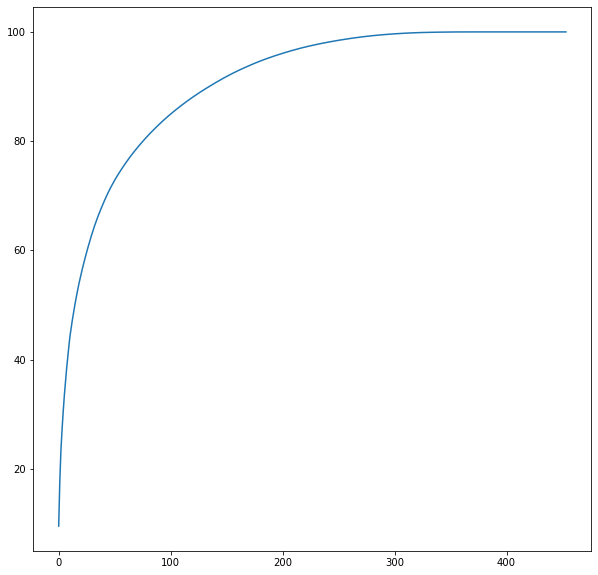

In [93]:

# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(10, 10))
plt.plot(cumulative_variance)
plt.show()

In [94]:
VARIANCE_FRACTION = 0.9

In [95]:

# PCA with 90% variance
pca = PCA(VARIANCE_FRACTION)
pca.fit_transform(X_train_bal)
print(f"{VARIANCE_FRACTION*100}% variance is explained by {pca.n_components_} principle components")



90.0% variance is explained by 136 principle components


In [96]:
all_metrics = []

# Classification with PCA

## Logistic Regression

In [97]:
pipeline = Pipeline([("pca", PCA(VARIANCE_FRACTION)),
                     ("logistic", LogisticRegression())])



In [98]:
# fit model
pipeline.fit(X_train_bal, y_train_bal)



Pipeline(steps=[('pca', PCA(n_components=0.9)),
                ('logistic', LogisticRegression())])

In [99]:
# check score on train data
pipeline.score(X_train_bal, y_train_bal)


0.868462829409897

#### evaluate on test data

In [100]:
y_pred = pipeline.predict(X_test)


In [101]:
confusion_matrix(y_test, y_pred)


array([[4791,  722],
       [  94,  394]], dtype=int64)

In [102]:

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print(f"Sensitivity: {round(sensitivity, 2)}")
print(f"Specificity: {round(specificity, 2)}")


Sensitivity: 0.81
Specificity: 0.87


In [103]:
# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print(f"AUC: {round(roc_auc_score(y_test, y_pred_prob), 2)}")

AUC: 0.91


In [104]:

all_metrics.append(["Logistic Regression", round(sensitivity, 2), round(specificity, 2), round(roc_auc_score(y_test, y_pred_prob), 2)])


## Logistic Regression with hyper parameter tuning

In [1]:

# 5 fold randomized search CV
model = GridSearchCV(
    estimator=Pipeline([('pca', PCA()), ("logistic", LogisticRegression())]),
    cv=KFold(n_splits=5, shuffle=True, random_state=997),
    param_grid={'pca__n_components': [120, 130, 140, 150, 160, 180, 200], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']},
    scoring='roc_auc',
    n_jobs=5,
    verbose=1)

NameError: name 'GridSearchCV' is not defined

In [106]:
# train the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   19.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 560 out of 560 | elapsed:  5.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=997, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('logistic', LogisticRegression())]),
             n_jobs=5,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [120, 130, 140, 150, 160, 180,
                                               200]},
             scoring='roc_auc', verbose=1)

In [107]:
# cross validation results
pd.DataFrame(model.cv_results_)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            1.928         0.085            0.000           0.000   
1            1.902         0.026            0.000           0.000   
2            1.957         0.030            0.000           0.000   
3            2.038         0.031            0.000           0.000   
4            2.103         0.043            0.000           0.000   
5            2.477         0.063            0.000           0.000   
6            2.724         0.039            0.000           0.000   
7            2.720         0.076            0.049           0.018   
8            2.679         0.091            0.045           0.007   
9            2.898         0.121            0.043           0.008   
10           3.026         0.111            0.057           0.004   
11           3.134         0.063            0.045           0.009   
12           3.685         0.064            0.057           0.005   
13           3.836         0.056            0.056           0.009   
14           1.727         0.045            0.000           0.000   
15           1.799         0.026            0.000           0.000   
16           1.977         0.080            0.000           0.000   
17           1.984         0.040            0.000           0.000   
18           2.116         0.037            0.000           0.000   
19           2.418         0.041            0.000           0.000   
20           2.482         0.029            0.000           0.000   
21           2.473         0.070            0.043           0.005   
22           2.620         0.059            0.053           0.013   
23           2.943         0.113            0.048           0.004   
24           3.065         0.055            0.052           0.007   
25           3.152         0.076            0.051           0.002   
26           3.650         0.043            0.052           0.005   
27           3.824         0.052            0.062           0.009   
28           1.711         0.045            0.000           0.000   
29           1.799         0.010            0.000           0.000   
30           1.986         0.039            0.000           0.000   
31           2.057         0.043            0.000           0.000   
32           2.108         0.031            0.000           0.000   
33           2.481         0.031            0.000           0.000   
34           2.642         0.037            0.000           0.000   
35           2.484         0.060            0.056           0.013   
36           2.658         0.086            0.045           0.005   
37           2.939         0.086            0.052           0.004   
38           3.123         0.096            0.059           0.008   
39           3.173         0.035            0.044           0.006   
40           3.609         0.073            0.056           0.006   
41           3.822         0.102            0.059           0.009   
42           1.718         0.037            0.000           0.000   
43           1.811         0.050            0.000           0.000   
44           2.049         0.044            0.000           0.000   
45           2.030         0.022            0.000           0.000   
46           2.187         0.027            0.000           0.000   
47           2.420         0.058            0.000           0.000   
48           2.529         0.070            0.000           0.000   
49           2.485         0.099            0.045           0.004   
50           2.719         0.137            0.055           0.009   
51           2.843         0.079            0.045           0.004   
52           3.113         0.032            0.057           0.009   
53           3.078         0.041            0.051           0.003   
54           3.592         0.091            0.050           0.004   
55           3.800         0.048            0.056           0.007   
56           1.713         0.038            0.000           0.000   
57 

In [108]:
# Best score and params
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)


Best AUC:  0.9152907514346662
Best hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'pca__n_components': 200}


In [109]:
# check score on train data
model.score(X_train_bal, y_train_bal)


0.9369945937172216

#### evaluate on test data

In [110]:
y_pred = model.predict(X_test)


In [111]:
confusion_matrix(y_test, y_pred)


array([[5413,  100],
       [ 268,  220]], dtype=int64)

In [112]:

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print(f"Sensitivity: {round(sensitivity, 2)}")
print(f"Specificity: {round(specificity, 2)}")


Sensitivity: 0.45
Specificity: 0.98


In [113]:
# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print(f"AUC: {round(roc_auc_score(y_test, y_pred_prob), 2)}")

AUC: 0.91


In [114]:

all_metrics.append(["Logistic Regression With Grid Search", round(sensitivity, 2), round(specificity, 2), round(roc_auc_score(y_test, y_pred_prob), 2)])



## Random forest

In [115]:
pipeline = Pipeline([("pca", PCA(VARIANCE_FRACTION)),
                     ("rf", RandomForestClassifier())])



In [116]:
# fit model
pipeline.fit(X_train_bal, y_train_bal)



Pipeline(steps=[('pca', PCA(n_components=0.9)),
                ('rf', RandomForestClassifier())])

In [117]:
# check score on train data
pipeline.score(X_train_bal, y_train_bal)


1.0

#### evaluate on test data

In [118]:
y_pred = pipeline.predict(X_test)


In [119]:
confusion_matrix(y_test, y_pred)


array([[5357,  156],
       [ 239,  249]], dtype=int64)

In [120]:

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print(f"Sensitivity: {round(sensitivity, 2)}")
print(f"Specificity: {round(specificity, 2)}")


Sensitivity: 0.51
Specificity: 0.97


In [121]:
# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print(f"AUC: {round(roc_auc_score(y_test, y_pred_prob), 2)}")

AUC: 0.89


In [122]:

all_metrics.append(["Random Forest", round(sensitivity, 2), round(specificity, 2), round(roc_auc_score(y_test, y_pred_prob), 2)])


## Random Forest with hyper parameter tuning

In [123]:

# 5 fold randomized search CV
model = RandomizedSearchCV(
    estimator=Pipeline([('pca', PCA()), ("rf", RandomForestClassifier())]),
    cv=KFold(n_splits=5, shuffle=True, random_state=997),
    param_distributions={'pca__n_components': [120, 130, 140, 150, 160, 180, 200],
                         'rf__n_estimators': [10, 20, 50, 100, 150, 200],
                         'rf__max_depth': [5, 10, 20, 50, 100],
                         'rf__min_samples_split': [2, 5, 10, 20, 50, 100],
                         'rf__min_samples_leaf': [2, 5, 10, 20, 50, 100]},
    scoring='roc_auc',
    n_jobs=5,
    verbose=1)

In [124]:
# train the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  2.4min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=997, shuffle=True),
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('rf', RandomForestClassifier())]),
                   n_jobs=5,
                   param_distributions={'pca__n_components': [120, 130, 140,
                                                              150, 160, 180,
                                                              200],
                                        'rf__max_depth': [5, 10, 20, 50, 100],
                                        'rf__min_samples_leaf': [2, 5, 10, 20,
                                                                 50, 100],
                                        'rf__min_samples_split': [2, 5, 10, 20,
                                                                  50, 100],
                                        'rf__n_estimators': [10, 20, 50, 100,
                                                             150, 2

In [125]:
# cross validation results
pd.DataFrame(model.cv_results_)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          3.521         0.038            0.045           0.003   
1         60.869         0.406            0.285           0.078   
2          2.994         0.124            0.046           0.012   
3          3.894         0.094            0.045           0.009   
4          4.101         0.045            0.052           0.010   
5         33.209         0.218            0.201           0.053   
6          3.677         0.057            0.046           0.006   
7         10.303         0.186            0.079           0.016   
8         17.045         0.050            0.132           0.030   
9          5.661         0.213            0.037           0.002   

  param_rf__n_estimators param_rf__min_samples_split  \
0                     10                         100   
1                    200                           5   
2                     10                          10   
3                     10                          20   
4                     20                          10   
5                    200                           2   
6                     10                         100   
7                     50                          10   
8                    200                         100   
9                     20                         100   

  param_rf__min_samples_leaf param_rf__max_depth param_pca__n_components  \
0                          2                   5                     160   
1                          5                  20                     200   
2                         50                  10                     130   
3                         20                  50                     140   
4                        100                   5                     180   
5                          5                  10                     160   
6                        100                  10                     180   
7                        100                  20                     150   
8                         20                   5                     130   
9                         10                  10                     200   

                                                                                                params  \
0  {'rf__n_estimators': 10, 'rf__min_samples_split': 100, 'rf__min_samples_leaf': 2, 'rf__max_depth...   
1  {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 5, 'rf__max_depth'...   
2  {'rf__n_estimators': 10, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 50, 'rf__max_depth...   
3  {'rf__n_estimators': 10, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 20, 'rf__max_depth...   
4  {'rf__n_estimators': 20, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 100, 'rf__max_dept...   
5  {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 5, 'rf__max_depth'...   
6  {'rf__n_estimators': 10, 'rf__min_samples_split': 100, 'rf__min_samples_leaf': 100, 'rf__max_dep...   
7  {'rf__n_estimators': 50, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 100, 'rf__max_dept...   
8  {'rf__n_estimators': 200, 'rf__min_samples_split': 100, 'rf__min_samples_leaf': 20, 'rf__max_dep...   
9  {'rf__n_estimators': 20, 'rf__min_samples_split': 100, 'rf__min_samples_leaf': 10, 'rf__max_dept...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0              0.853              0.844              0.862              0.852   
1              0.889              0.874              0.894              0.887   
2              0.875              0.851              0.868              0.873   
3              0.867              0.864              0.868              0.874   
4              0.855              0.854              0.852              0.854   
5              0.884              0.877              0.893              0.885   
6              0.874              0.864              0.877              0.874

In [126]:
# Best score and params
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)


Best AUC:  0.8873520290726395
Best hyperparameters:  {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 5, 'rf__max_depth': 20, 'pca__n_components': 200}


In [127]:
# check score on train data
model.score(X_train_bal, y_train_bal)


0.9570339312854288

#### evaluate on test data

In [128]:
y_pred = model.predict(X_test)


In [129]:
confusion_matrix(y_test, y_pred)


array([[5479,   34],
       [ 351,  137]], dtype=int64)

In [130]:

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print(f"Sensitivity: {round(sensitivity, 2)}")
print(f"Specificity: {round(specificity, 2)}")


Sensitivity: 0.28
Specificity: 0.99


In [131]:
# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print(f"AUC: {round(roc_auc_score(y_test, y_pred_prob), 2)}")

AUC: 0.89


In [132]:

all_metrics.append(["Random Forest With Randomized Search", round(sensitivity, 2), round(specificity, 2), round(roc_auc_score(y_test, y_pred_prob), 2)])


## Gradient Boosting

In [133]:
pipeline = Pipeline([("pca", PCA(VARIANCE_FRACTION)),
                     ("gb", GradientBoostingClassifier())])



In [134]:
# fit model
pipeline.fit(X_train_bal, y_train_bal)



Pipeline(steps=[('pca', PCA(n_components=0.9)),
                ('gb', GradientBoostingClassifier())])

In [135]:
# check score on train data
pipeline.score(X_train_bal, y_train_bal)


0.8907334331201524

#### evaluate on test data

In [136]:
y_pred = pipeline.predict(X_test)


In [137]:
confusion_matrix(y_test, y_pred)


array([[4949,  564],
       [ 125,  363]], dtype=int64)

In [138]:

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print(f"Sensitivity: {round(sensitivity, 2)}")
print(f"Specificity: {round(specificity, 2)}")


Sensitivity: 0.74
Specificity: 0.9


In [139]:
# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print(f"AUC: {round(roc_auc_score(y_test, y_pred_prob), 2)}")

AUC: 0.9


In [140]:

all_metrics.append(["Gradient Boosting", round(sensitivity, 2), round(specificity, 2), round(roc_auc_score(y_test, y_pred_prob), 2)])


## Gradient Boosting with hyper parameter tuning

In [141]:

# 5 fold randomized search CV
model = RandomizedSearchCV(
    estimator=Pipeline([('pca', PCA()), ("gb", GradientBoostingClassifier())]),
    cv=KFold(n_splits=5, shuffle=True, random_state=997),
    param_distributions={'pca__n_components': [120, 130, 140, 150, 160, 180, 200],
                         'gb__loss': ['deviance', 'exponential'],
                         'gb__learning_rate': [0.01, 0.1, 1, 10],
                         'gb__n_estimators': [10, 20, 50, 100, 150, 200]},
    scoring='roc_auc',
    n_jobs=5,
    verbose=1)

In [142]:
# train the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  9.5min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=997, shuffle=True),
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('gb',
                                              GradientBoostingClassifier())]),
                   n_jobs=5,
                   param_distributions={'gb__learning_rate': [0.01, 0.1, 1, 10],
                                        'gb__loss': ['deviance', 'exponential'],
                                        'gb__n_estimators': [10, 20, 50, 100,
                                                             150, 200],
                                        'pca__n_components': [120, 130, 140,
                                                              150, 160, 180,
                                                              200]},
                   scoring='roc_auc', verbose=1)

In [143]:
# cross validation results
pd.DataFrame(model.cv_results_)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        123.158         0.527            0.059           0.017   
1          9.519         0.094            0.036           0.006   
2        150.043         0.710            0.043           0.004   
3         37.339         0.313            0.040           0.009   
4         16.038         0.123            0.038           0.007   
5         10.155         0.097            0.034           0.005   
6         80.084         0.422            0.042           0.004   
7         56.406         0.239            0.038           0.004   
8         41.250         0.224            0.036           0.005   
9         46.718         0.311            0.027           0.001   

  param_pca__n_components param_gb__n_estimators param_gb__loss  \
0                     200                    100    exponential   
1                     130                     10       deviance   
2                     160                    150    exponential   
3                     120                     50       deviance   
4                     120                     20       deviance   
5                     140                     10    exponential   
6                     130                    100    exponential   
7                     180                     50       deviance   
8                     130                     50       deviance   
9                     150                     50    exponential   

  param_gb__learning_rate  \
0                       1   
1                    0.01   
2                      10   
3                     0.1   
4                    0.01   
5                       1   
6                       1   
7                      10   
8                       1   
9                    0.01   

                                                                                                params  \
0  {'pca__n_components': 200, 'gb__n_estimators': 100, 'gb__loss': 'exponential', 'gb__learning_rat...   
1  {'pca__n_components': 130, 'gb__n_estimators': 10, 'gb__loss': 'deviance', 'gb__learning_rate': ...   
2  {'pca__n_components': 160, 'gb__n_estimators': 150, 'gb__loss': 'exponential', 'gb__learning_rat...   
3  {'pca__n_components': 120, 'gb__n_estimators': 50, 'gb__loss': 'deviance', 'gb__learning_rate': ...   
4  {'pca__n_components': 120, 'gb__n_estimators': 20, 'gb__loss': 'deviance', 'gb__learning_rate': ...   
5  {'pca__n_components': 140, 'gb__n_estimators': 10, 'gb__loss': 'exponential', 'gb__learning_rate...   
6  {'pca__n_components': 130, 'gb__n_estimators': 100, 'gb__loss': 'exponential', 'gb__learning_rat...   
7  {'pca__n_components': 180, 'gb__n_estimators': 50, 'gb__loss': 'deviance', 'gb__learning_rate': 10}   
8   {'pca__n_components': 130, 'gb__n_estimators': 50, 'gb__loss': 'deviance', 'gb__learning_rate': 1}   
9  {'pca__n_components': 150, 'gb__n_estimators': 50, 'gb__loss': 'exponential', 'gb__learning_rate...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0              0.897              0.884              0.902              0.885   
1              0.824              0.767              0.814              0.814   
2              0.538              0.269              0.316              0.699   
3              0.896              0.896              0.909              0.896   
4              0.826              0.768              0.825              0.816   
5              0.890              0.879              0.895              0.880   
6              0.889              0.884              0.898              0.875   
7              0.791              0.245              0.588              0.274   
8              0.853              0.857              0.862              0.738   
9              0.853              0.850              0.861              0.845   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0              0.885            0.891           0.007                2  
1 

In [144]:
# Best score and params
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)


Best AUC:  0.8968701625497941
Best hyperparameters:  {'pca__n_components': 120, 'gb__n_estimators': 50, 'gb__loss': 'deviance', 'gb__learning_rate': 0.1}


In [145]:
# check score on train data
model.score(X_train_bal, y_train_bal)


0.9144398088383976

### evaluate on test data

In [146]:
y_pred = model.predict(X_test)


In [147]:
confusion_matrix(y_test, y_pred)


array([[5429,   84],
       [ 290,  198]], dtype=int64)

In [148]:

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print(f"Sensitivity: {round(sensitivity, 2)}")
print(f"Specificity: {round(specificity, 2)}")


Sensitivity: 0.41
Specificity: 0.98


In [149]:
# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print(f"AUC: {round(roc_auc_score(y_test, y_pred_prob), 2)}")

AUC: 0.89


In [150]:

all_metrics.append(["Gradient Boosting With Randomized Search", round(sensitivity, 2), round(specificity, 2), round(roc_auc_score(y_test, y_pred_prob), 2)])



In [151]:
# Performance comparisions
pef_comparision_matrix = pd.DataFrame(all_metrics, columns=["Algo", "Sensitivity", "Specificity", "AUC"])
pef_comparision_matrix.style.hide_index()

Model for Feature Importance

In [152]:
estimator = LogisticRegression()
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(X_train_bal, y_train_bal)
display(selector.support_)
display(selector.ranking_)

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False,  True,  True,  True,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

array([343, 249,   1,  14,   2, 214, 410, 168,  52, 165, 104,  55,  57,
        58,  54, 128,  34,  35,   8,  33, 158,   1,  94, 411, 384, 164,
       170, 396,  32, 121,   9, 409, 215, 161,   3,  51, 285, 296, 139,
       122,  81,  10,   6, 250, 357, 124, 335, 420, 232, 254, 255, 419,
       200,   1,  56,   1, 151,   1,   1,   1,   1, 358, 147, 377,   1,
       150, 421, 110, 172, 173, 111,  60,  61, 112, 280, 371, 107,  62,
        25,  96, 133, 149, 378, 152,   1, 108, 394, 295, 220, 341, 380,
        74,  69,  16, 241, 332,   1,  77, 434, 198, 415, 237, 238,  64,
         1,   1,  75,  86, 119,  72, 292, 118, 276, 132, 117, 360, 218,
       116,  29, 131,  24,  65, 386, 120,  88,  87,  31,  95, 289, 181,
        40,  48,  49, 349, 284,  18,  17, 189,  19,   1,  76,  73,   1,
       183,   1, 210, 388,  93, 130,  26, 342, 370, 315, 397, 127, 126,
       191, 228, 216, 243, 261, 167, 166,  11, 188, 267, 103, 160, 301,
       317, 302, 321,   1, 316, 303, 418, 407, 247,  59,  21, 42

In [153]:
features = pd.DataFrame()

In [154]:
features["Column"] = X_train_bal.columns
features["Rank"] = selector.ranking_


In [155]:
# Set importance and Coefficient
features_importance = features[selector.support_]
features_importance.reset_index(drop=True, inplace=True)
importance_frame = features_importance.reindex()
importance_frame["Coefficient"] = list(selector.estimator_.coef_[0])
importance_frame["Importance"] = list(np.abs(selector.estimator_.coef_)[0])
importance_frame = importance_frame.sort_values(by="Importance", ascending=False)
importance_frame["Direction"] = importance_frame["Coefficient"].apply(lambda x: "Pos" if x > 0 else "Neg")

In [156]:
importance_frame[["Column", "Importance", "Direction"]].style.hide_index()